# Transfer Learning with Tensorflow Part 2: Fine-Tuning

In previous notebook, we learned about transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: `fine-tuning`.

## Creating helper functions 

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

In [1]:
import wget 

In [2]:
wget.download('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py')

100% [..............................................................................] 10246 / 10246

'helper_functions (1).py'

In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).


In [4]:
# Check out how many images and subdirectories are in our dataset 
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
# Create training and test directory paths 
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'


In [6]:
import tensorflow as tf 

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the class names of our dataset 
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# see an example of a batch of data 
for images, labels in train_data_10_percent.take(1): # unravel a batch
     print(images, labels)
    

tf.Tensor(
[[[[1.51229584e+02 1.22285713e+02 7.49030609e+01]
   [1.44239792e+02 1.17454086e+02 7.90051041e+01]
   [1.32433670e+02 1.11362244e+02 8.41581650e+01]
   ...
   [1.95714073e+01 7.57140684e+00 7.57140684e+00]
   [2.04285851e+01 6.42858458e+00 6.42858458e+00]
   [2.20714626e+01 8.07146358e+00 8.07146358e+00]]

  [[1.35663269e+02 1.15306122e+02 7.98775482e+01]
   [1.27168365e+02 1.09602036e+02 8.08877563e+01]
   [1.27903061e+02 1.13102043e+02 9.44336853e+01]
   ...
   [2.05867767e+01 7.01530457e+00 7.01530457e+00]
   [2.19285717e+01 5.92857170e+00 6.92857170e+00]
   [2.29285717e+01 6.92857170e+00 7.92857170e+00]]

  [[1.23964287e+02 1.16821426e+02 9.87602005e+01]
   [1.38469391e+02 1.32198990e+02 1.17612251e+02]
   [1.49801025e+02 1.44086731e+02 1.35877563e+02]
   ...
   [2.16887932e+01 5.26022148e+00 5.26022148e+00]
   [2.44285717e+01 6.00000000e+00 6.21428585e+00]
   [2.52142868e+01 6.78571415e+00 7.00000000e+00]]

  ...

  [[2.03418388e+01 9.34183788e+00 5.34183836e+00]
   [2

In [12]:
# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

## Model 0: Building a transfer learning model usinga keras functional API 

The sequential API is straight forward, it runs our layers in sequential order.

However the functional API gives us more flexibility with our models.

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

In [12]:
# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False 

# 3. Create inputs into our model 
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model 
x = base_model(inputs)
print(f'Shape after passing inputs through the base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after Global Average Pooling 2D: {x.shape}')

# 7. Create the output activation layer 
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model 
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model 
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# 10. Fit the model and save it's history
history_10_percent = model_0.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25*len(test_data)),
                                 callbacks=[create_tensorboard_callback('transfer_learning',
                                                                       '10_percent_feature_extraction')])


                                 

    


Shape after passing inputs through the base model: (None, 7, 7, 1280)
Shape after Global Average Pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20251003-105851
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 906ms/step - accuracy: 0.3787 - loss: 1.9321 - val_accuracy: 0.7056 - val_loss: 1.3397
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 742ms/step - accuracy: 0.7440 - loss: 1.1726 - val_accuracy: 0.7961 - val_loss: 0.9077
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 699ms/step - accuracy: 0.8267 - loss: 0.8663 - val_accuracy: 0.8454 - val_loss: 0.7201
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 657ms/step - accuracy: 0.8520 - loss: 0.6963 - val_accuracy: 0.8553 - val_loss: 0.6165
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 657ms/step - accuracy: 0.8640 - loss: 0.6056 - val_accuracy: 0.8520 - val_loss: 0.5838


In [13]:
# Evaluate on the full test dataset 
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 383ms/step - accuracy: 0.8548 - loss: 0.5740


[0.5740074515342712, 0.8547999858856201]

In [14]:
# Check the layers in our base model 
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer_1
1 rescaling_1
2 normalization_1
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_con

In [15]:
# How about we get a summary of the  model ? 
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

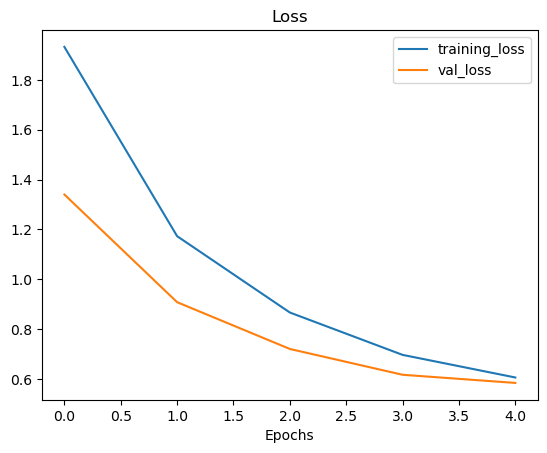

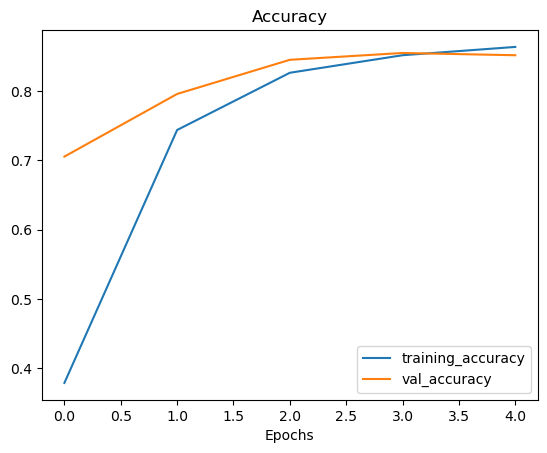

In [16]:
# Check out our model's training curves 
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model 

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.


In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer 
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

# Check the shape of the different tensor 
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooling 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooling 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer 
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of training data, but how does it go with 1% of training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

Note: Throughout all experiments the same test dataset will be use to evaluate our model.... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [33]:
# Download and unzip data - preprocessed from Food101
wget.download('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip')

100% [......................................................................] 133612354 / 133612354

'10_food_classes_1_percent.zip'

In [19]:
unzip_data('10_food_classes_1_percent.zip')

In [20]:
# Create training and test dirs 
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [21]:
# How many images are we working with 
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [22]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir_1_percent,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE   
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model 

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`



In [23]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 

In [24]:
# Create data augmentaion stage with horizontal flipping, rotations, zooms etc
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    #layers.Rescaling(1./255) # Keep for models like ResNet50V2 but effnet have rescaling built-in
], name='data_augmentation')
data_augmentation.build(input_shape=(None, 224, 224, 3))

### Visualize our data augmentation layer

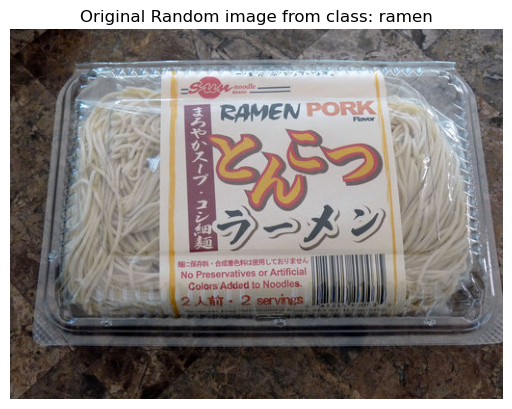

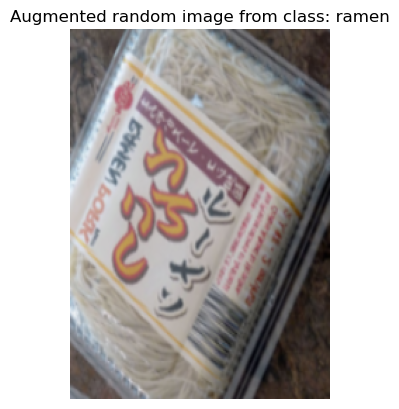

In [45]:
# View a random image and compare it with the augmented version 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import os 
import random 
# Choose a random image
target_class = random.choice(train_data_1_percent.class_names)
target_dir = os.path.join('10_food_classes_1_percent/train', target_class)
random_image = random.choice(os.listdir(target_dir))
random_image_path = os.path.join(target_dir, random_image)

# Load and show original image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original Random image from class: {target_class}')
plt.axis('off')
plt.show()

# Augment and show
img = tf.expand_dims(tf.image.resize(img, size=(224, 224)), axis=0)
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img) / 255.)  
plt.title(f'Augmented random image from class: {target_class}')
plt.axis('off')
plt.show()


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [46]:
# Setup input shape and base model, freezing the base model layers 
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False 

# Create input layer 
inputs = layers.Input(shape=input_shape)

# Add in data augmentation Sequential model as a layer 
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it.
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output 
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# make a model using the inputs and outputs 
model_1 = keras.Model(inputs, outputs)


# compile the model 
model_1.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model 
history_1_percent = model_1.fit(train_data_1_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_1_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25 * len(test_data)),
                               # Track model training logs
                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='1_percent_data_aug')])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20251003-111603
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.0714 - loss: 2.4280 - val_accuracy: 0.1628 - val_loss: 2.2905
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.1714 - loss: 2.2051 - val_accuracy: 0.2023 - val_loss: 2.1895
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.3143 - loss: 2.0106 - val_accuracy: 0.2434 - val_loss: 2.0956
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.5143 - loss: 1.8579 - val_accuracy: 0.3207 - val_loss: 1.9879
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.4429 - loss: 1.8067 - val_accuracy: 0.3602 - val_loss: 1.9262


In [83]:
# Check out a model summary 
model_1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [84]:
# Evaluate on full test dataset 
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 433ms/step - accuracy: 0.4000 - loss: 1.8836


[1.8835681676864624, 0.4000000059604645]

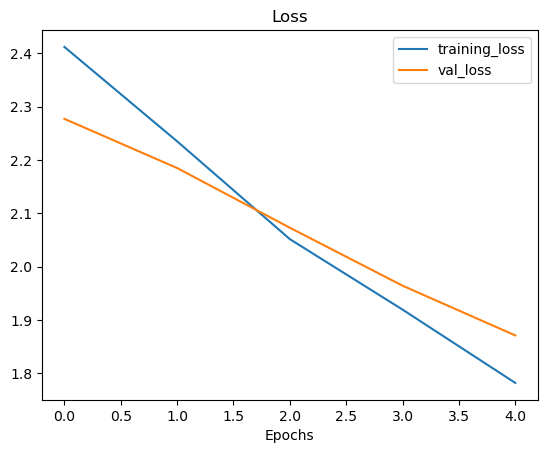

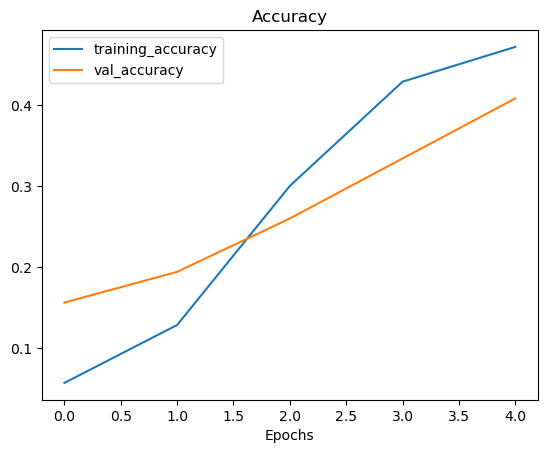

In [85]:
# How do the model with 1% of data and data augmentation loss curves look? 
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction transfer learning model with 10% data with data augmentation

In [47]:
# Get 10% of data... (uncomment if you don't have it)
# wget.download('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip')
# unzip_data(10_food_classes_10_percent)

train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'


In [49]:
# How many images are in our directory? 
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [48]:
# Set data inputs
import tensorflow as tf 
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode='categorical',
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [55]:
# Create model 2 with data augmentation build it.
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential

# Build data augmentation layer 
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    # layers.Rescaling(1./255) # if you are using a model such a ResNet50V2, you'll need to rescale your data, effnet has rescaling built in.
    
], name = 'data_augmentation')

# Setup the input shape to our model 
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False 

# Create the inputs and outputs (including the layers in between)
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur in test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated.
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile 
model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])



In [56]:
model_2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_2D            │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model 
(the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [58]:
# Set checkpoint path 
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.weights.h5'

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq='epoch',
                                                        verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [59]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                          experiment_name='10_percent_data_aug'),
              checkpoint_callback]
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20251003-114837
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.2254 - loss: 2.2334 
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3293 - loss: 2.0685 - val_accuracy: 0.6595 - val_loss: 1.5266
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.5859 - loss: 1.5366 
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 802ms/step - accuracy: 0.5987 - loss: 1.4605 - val_accuracy: 0.7336 - val_loss: 1.1039
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6984 - loss: 1.2117 
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 830ms/step - accuracy: 0.7013 - loss: 1.1754 - val_accuracy: 0.7664 - val_loss: 0.8834
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/ste

In [60]:
# What were model_0 results
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 413ms/step - accuracy: 0.8548 - loss: 0.5740


[0.5740074515342712, 0.8547999858856201]

In [62]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 441ms/step - accuracy: 0.8132 - loss: 0.6870


[0.6869791150093079, 0.8131999969482422]

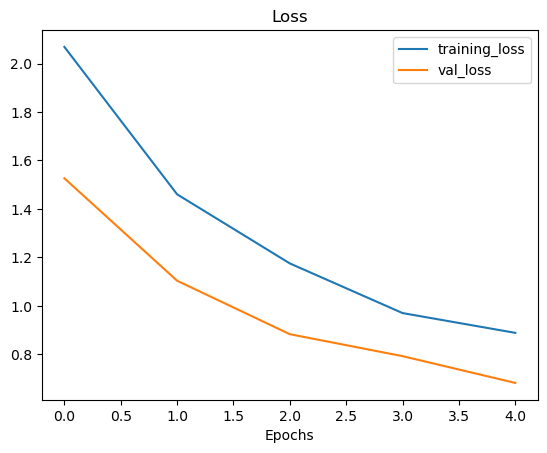

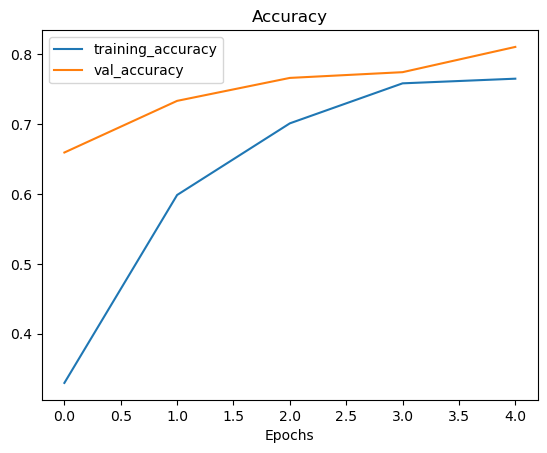

In [63]:
# Plot model loss curves 
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights 

Loading in checkpointed weights returns a model to a specific checkpoint.

In [65]:
# Load in saved model weights and evaluate model 
model_2.load_weights(checkpoint_path)

In [67]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)


79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 402ms/step - accuracy: 0.8132 - loss: 0.6870


In [68]:
# If the results from our previously evaluated model_2 match the loaded weights, everything was worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [69]:
results_10_percent_data_aug

[0.6869791150093079, 0.8131999969482422]

In [70]:
loaded_weights_model_results

[0.6869788765907288, 0.8131999969482422]

In [71]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np 
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

## Model 3: Fine-Tuning an existing model on 10% of training data.

> **NOTE:** Fine Tuning usually works best after training a feature extraction model for a few epochs with large amount of custom data.

In [73]:
# Layers in loaded model 
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_2D, built=True>,
 <Dense name=output_layer, built=True>]

In [74]:
# Are these layers trainable? 
for layer in model_2.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation, built=True> True
<Functional name=efficientnetv2-b0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_2D, built=True> True
<Dense name=output_layer, built=True> True


In [82]:
# What layers are in our base_model (Efficientnet) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, "|", layer.trainable)

0 input_layer_9 | False
1 rescaling_5 | False
2 normalization_5 | False
3 stem_conv | False
4 stem_bn | False
5 stem_activation | False
6 block1a_project_conv | False
7 block1a_project_bn | False
8 block1a_project_activation | False
9 block2a_expand_conv | False
10 block2a_expand_bn | False
11 block2a_expand_activation | False
12 block2a_project_conv | False
13 block2a_project_bn | False
14 block2b_expand_conv | False
15 block2b_expand_bn | False
16 block2b_expand_activation | False
17 block2b_project_conv | False
18 block2b_project_bn | False
19 block2b_drop | False
20 block2b_add | False
21 block3a_expand_conv | False
22 block3a_expand_bn | False
23 block3a_expand_activation | False
24 block3a_project_conv | False
25 block3a_project_bn | False
26 block3b_expand_conv | False
27 block3b_expand_bn | False
28 block3b_expand_activation | False
29 block3b_project_conv | False
30 block3b_project_bn | False
31 block3b_drop | False
32 block3b_add | False
33 block4a_expand_conv | False
34 bloc

In [83]:
# How many trainable variables are in our base model? 
print(len(model_2.layers[2].trainable_variables))

0


In [84]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True 
base_model.trainable = True 

# Freeze all layers except for last 10 layers 
for layer in base_model.layers[:-10]:
    layer.trainable = False 

# Recompile (we have to recompile our models everytime we make a change)
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate by 10x in fine-tuning (just rule of thumb)
    metrics=['accuracy']
)



> **Note:** When using fine tuning it's best practice to lower your learning rate by some amount . This is a hyperparameter you can tune but a rule of thumb is atleast 10x though different sources would claim other values. A good resource on this is UMLFIT paper

In [85]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_9 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [86]:
# Now we've unfrozen some of the layers closer to the top, how many trainables are there? 
print(len(model_2.trainable_variables))

12


In [88]:
# Fine tune for another 5 epochs 
fine_tune_epochs = initial_epochs + 5 

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs=fine_tune_epochs,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
    callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                          experiment_name='10_percent_fine_tune_last_10')]
    
)

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20251003-142736
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7507 - loss: 1.0026 - val_accuracy: 0.8158 - val_loss: 0.7133
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7800 - loss: 0.9092 - val_accuracy: 0.8158 - val_loss: 0.6509
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7907 - loss: 0.8044 - val_accuracy: 0.8191 - val_loss: 0.6276
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8013 - loss: 0.7824 - val_accuracy: 0.8372 - val_loss: 0.5651
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8107 - loss: 0.7299 - val_accuracy: 0.8405 - val_loss: 0.5399
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8147 - loss: 0.6847 - val_accuracy: 0.8421 - val_loss: 0.5132


In [89]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 416ms/step - accuracy: 0.8512 - loss: 0.5074


In [90]:
results_10_percent_data_aug

[0.6869791150093079, 0.8131999969482422]

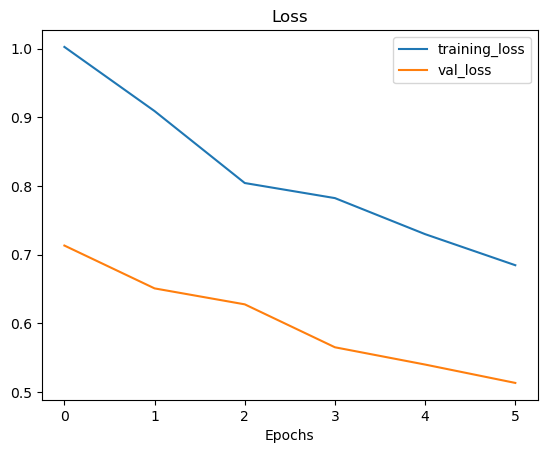

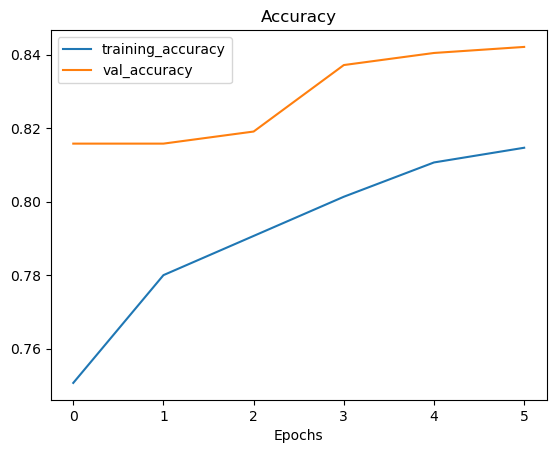

In [91]:
# Check out the loss curves of our fine-tuned model 
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [103]:
# Let's create a function to compare training histories 
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two tensorflow history objects.
    """
    # Get original history measurements 
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Val Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title("Training and Validation Accuracy")

    # Make plots for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Val Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title("Training and Validation Loss")



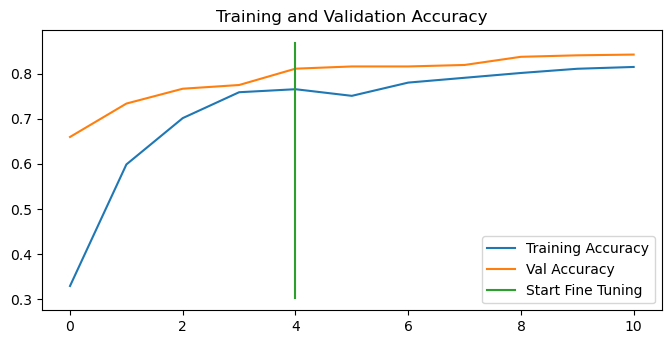

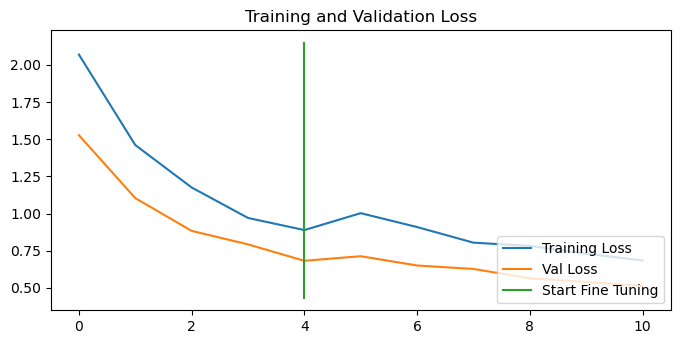

In [104]:
compare_historys(history_10_percent_data_aug, history_fine_10_percent_data_aug, initial_epochs=5)

## Model 4: Fine-tuning an existing model on whole training data

In [105]:
# Download and unzip 10 classes of Food101 data with all images
# wget.download('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip')
# unzip_data('10_food_classes_all_data')


In [106]:
# Setup training and test dir 
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [107]:
# How many images are we working with now? 
walk_through_dir('10_food_classes_all_data')

There are 3 directories and 0 images in '10_food_classes_all_data'.
There are 0 directories and 1 images in '10_food_classes_all_data\.ipynb_checkpoints'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
Ther

In [108]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode='categorical',
    image_size=IMG_SIZE
    
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).
let's verify this.

In [109]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 426ms/step - accuracy: 0.8512 - loss: 0.5074


[0.5073582530021667, 0.8511999845504761]

In [110]:
results_fine_tune_10_percent

[0.5073582530021667, 0.8511999845504761]

To train a fine-tuning model (model_4) we need to revert model_2 back to it's feature extraction weights.

In [112]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent model was fine-tuned from.
model_2.load_weights(checkpoint_path)

C:\Users\yashs\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [113]:
# Let's evaluate model_2 now 
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 415ms/step - accuracy: 0.8132 - loss: 0.6870


[0.6869791150093079, 0.8131999969482422]

In [115]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6869791150093079, 0.8131999969482422]

Alright, the previous steps might seem quite confusing but all we have done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2. except this time we're going to use all of the data (model_4)

In [116]:
# Check which layers are tunable in the whole model 
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_2D True
4 output_layer True


In [117]:
# Let's drill into our base_model (effecientnetB0) and see what layers are trainable
for layer_number, layer in  enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_9 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [118]:
# Compile 
model_2.compile(loss='categorical_crossentropy', 
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])


In [120]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5 

history_fine_10_classes_full = model_2.fit(
    train_data_10_classes_full,
    epochs=fine_tune_epochs,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    initial_epoch=history_10_percent_data_aug.epoch[-1],
    callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                          experiment_name='full_10_classes_fine_tune_last_10')]
    
)

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20251003-150511
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 248s 928ms/step - accuracy: 0.7491 - loss: 0.9088 - val_accuracy: 0.8421 - val_loss: 0.4736
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 195s 828ms/step - accuracy: 0.7884 - loss: 0.7155 - val_accuracy: 0.8898 - val_loss: 0.3696
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 212s 905ms/step - accuracy: 0.8055 - loss: 0.6379 - val_accuracy: 0.8849 - val_loss: 0.3597
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.8143 - loss: 0.5891 - val_accuracy: 0.8980 - val_loss: 0.3354
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8293 - loss: 0.5563 - val_accuracy: 0.8931 - val_loss: 0.3125
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8289 - loss: 0.5376 - val_accuracy: 0.9013 - val_loss: 0.2870


In [ ]:
# Let's evaluate on alll of the test data 
results_fine_tune_full_data = model_2.evaluate(test_data)

61/79 ━━━━━━━━━━━━━━━━━━━━ 12s 684ms/step - accuracy: 0.9035 - loss: 0.2847 

In [ ]:
results_fine_tune_full_data

In [ ]:
# How did fine-tuning go with more data? 
compare_historys(original_history=history_10_percent_data_aug, 
                new_history=history_fine_10_classes_full,
                initial_epochs=5)


## Viewing our Experiment data on TensorBoard 


In [1]:
%load_ext tensorboard
%tensorboard --logdir transfer_learning


## Exercises

#### 1. Use feature-extraction to train a transfer learning model on 10% of Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [3]:
import tensorflow as tf 

In [6]:

# Let's create train and test dir
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

# Load the data 
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=(224, 224)
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(224, 224)
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [17]:
# 1. Create base model with tf.keras.applications 

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remains)
base_model.trainable = False 

# 3. Create inputs into the base model 
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. Pass the inputs to the base model
x = base_model(inputs)

# 5. Average pool the ouputs of the base model (agg all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# 6. Create the output activation layer 
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 7. Create the output activation layer 
model_0 = tf.keras.Model(inputs, outputs)

# 8. Compile the model 
model_0.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])



In [18]:
# Creating a ModelCheckpoint callback 
checkpoint_path = 'ten_percent_model_checkpoints_weights_exercise/checkpoint.weights.h5'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True,
                                                        save_freq='epoch',
                                                        verbose=1)

In [19]:
from helper_functions import create_tensorboard_callback, plot_loss_curves

In [20]:
# Fit the model saving checkpoints every epoch
initial_epochs = 10
history_10_percent_exercise = model_0.fit(train_data,
                                         epochs=initial_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25 * len(test_data)),
                                         callbacks=[create_tensorboard_callback('exercise_transfer_learning', '10_percent_data_exercise'),
                                                   checkpoint_callback])

Saving TensorBoard log files to: exercise_transfer_learning/10_percent_data_exercise/20251005-192111
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.2616 - loss: 2.1691
Epoch 1: val_loss improved from None to 1.39559, saving model to ten_percent_model_checkpoints_weights_exercise/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 772ms/step - accuracy: 0.3960 - loss: 1.9312 - val_accuracy: 0.6957 - val_loss: 1.3956
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6971 - loss: 1.2691
Epoch 2: val_loss improved from 1.39559 to 0.93651, saving model to ten_percent_model_checkpoints_weights_exercise/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 652ms/step - accuracy: 0.7213 - loss: 1.1749 - val_accuracy: 0.7993 - val_loss: 0.9365
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7876 - loss: 0.9010 
Epoch 3: val_loss improved from 0.93651 to 0.75661, saving model to ten_percent_model_checkpoints_weights_exercise/checkpoint.weights

In [21]:
# Evaluate on the test data 
results_model_0 = model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 333ms/step - accuracy: 0.8736 - loss: 0.4534


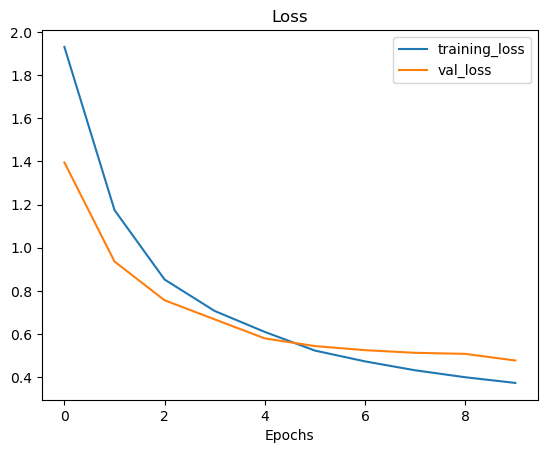

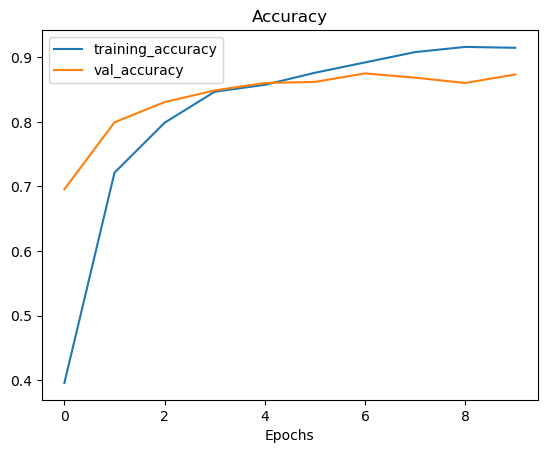

In [22]:
# Plot model loss curves 
plot_loss_curves(history_10_percent_exercise)

#### 2. Fine-tune the last 20 layers of the base model you trained  for another 10 epochs. How did it go?

In [23]:
model_0.layers

[<InputLayer name=input_layer, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [25]:
for layer_number, layer in enumerate(model_0.layers):
    print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")
    

Layer number: 0 | Layer name: input_layer | Layer type: <InputLayer name=input_layer, built=True> | Trainable? True
Layer number: 1 | Layer name: efficientnetv2-b0 | Layer type: <Functional name=efficientnetv2-b0, built=True> | Trainable? False
Layer number: 2 | Layer name: global_average_pooling_layer | Layer type: <GlobalAveragePooling2D name=global_average_pooling_layer, built=True> | Trainable? True
Layer number: 3 | Layer name: output_layer | Layer type: <Dense name=output_layer, built=True> | Trainable? True


In [27]:
model_0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [28]:
# Access the base_model layers of model_0
model_0_base_model = model_0.layers[1]
model_0_base_model.name

'efficientnetv2-b0'

In [31]:
# How many layers are trainable in our model_0_base_model?
print(len(model_0_base_model.trainable_variables)) # layer at index 1 is the EfficientNetV2B0 layer (the base model)

0


In [34]:
# Check which layers are tunable ( trainable)
for layer_number, layer in enumerate(model_0_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [37]:
# Make all the layers in model_0_base_model trainable 
model_0_base_model.trainable = True 

# Freeze all layers except for the last 20 
for layer in model_0_base_model.layers[:-20]:
    layer.trainable = False 

# Recompile the model (always recompile after any adjustments to a model)
model_0.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

In [38]:
# Let's check which layers of the pretrained model are trainable 
for layer_number, layer in enumerate(model_0_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [39]:
# How many trainable variables do we have now? 
print(len(model_0.trainable_variables))

18


In [45]:
# Fine tune for another 10 epochs 
fine_tune_epochs = initial_epochs + 10 

# Refit the model (same as model_0 except with more trainable layers)
history_fine_tune_10_percent_exercise = model_0.fit(train_data,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.25 * len(test_data)),
                                                   initial_epoch=history_10_percent_exercise.epoch[-1],
                                                   callbacks=[create_tensorboard_callback('exercise_transfer_learning', '10_percent_fine_tune_data_exercise')])

Saving TensorBoard log files to: exercise_transfer_learning/10_percent_fine_tune_data_exercise/20251005-193504
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 791ms/step - accuracy: 0.9013 - loss: 0.5314 - val_accuracy: 0.8684 - val_loss: 0.5410
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 692ms/step - accuracy: 0.9213 - loss: 0.4128 - val_accuracy: 0.8750 - val_loss: 0.5103
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 667ms/step - accuracy: 0.9307 - loss: 0.3798 - val_accuracy: 0.8849 - val_loss: 0.4750
Epoch 13/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 664ms/step - accuracy: 0.9373 - loss: 0.3537 - val_accuracy: 0.8997 - val_loss: 0.4350
Epoch 14/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 684ms/step - accuracy: 0.9520 - loss: 0.2953 - val_accuracy: 0.8750 - val_loss: 0.4592
Epoch 15/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 682ms/step - accuracy: 0.9467 - loss: 0.2790 - val_accuracy: 0.8849 - val_loss: 0.4304
Epoch 16/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 693ms/step - accuracy: 0.9560 - loss: 0.2491 - val_accuracy: 0.883

In [46]:
# Evaluate the model 
results_fine_tune_10_percent_exercise = model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 343ms/step - accuracy: 0.8888 - loss: 0.3666


In [49]:
import matplotlib.pyplot as plt
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

10
21
[0.3959999978542328, 0.7213333249092102, 0.7986666560173035, 0.846666693687439, 0.8573333621025085, 0.8759999871253967, 0.8920000195503235, 0.9079999923706055, 0.9160000085830688, 0.9146666526794434, 0.9013333320617676, 0.9213333129882812, 0.9306666851043701, 0.937333345413208, 0.9520000219345093, 0.9466666579246521, 0.9559999704360962, 0.9573333263397217, 0.9746666550636292, 0.972000002861023, 0.9760000109672546]


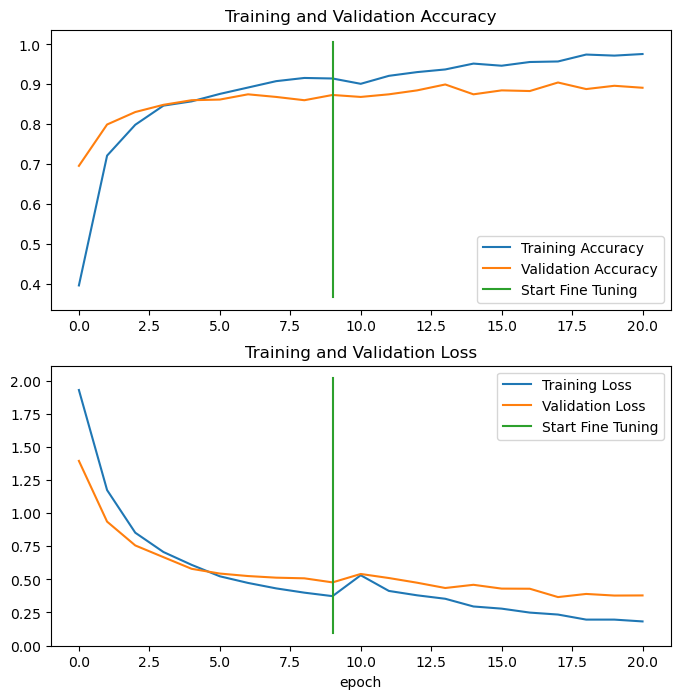

In [50]:
compare_historys(original_history=history_10_percent_exercise,
                new_history=history_fine_tune_10_percent_exercise,
                initial_epochs=10)

**Seems like model is overfitting after fine-tuning**

#### 3. Fine-tune the last 30 layers of the base model you trained 1 for another 10 epochs. How did it go?

In [51]:
# let's reload the model from checkpoint file 
model_0.load_weights(checkpoint_path)
loaded_weights_model_results = model_0.evaluate(test_data)

C:\Users\yashs\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.8736 - loss: 0.4534


In [52]:
results_model_0

[0.4533897042274475, 0.8736000061035156]

In [71]:
# Access the base_model layers of model_0
model_0_base_model = model_0.layers[1]
print(model_0_base_model.name)

# Freeze all layers except for the last 30 
set_trainable = False
for layer in model_0_base_model.layers:
    if layer.name.startswith("block6h") or layer.name.startswith("top"):
        set_trainable = True
    layer.trainable = set_trainable

# Recompile the model (always recompile after any adjustments to a model)
model_0.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

efficientnetv2-b0


In [72]:
# Let's check which layers of the pretrained model are trainable 
for layer_number, layer in enumerate(model_0_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [74]:
print(len(model_0.trainable_variables))

18


In [75]:
# Fine tune for another 10 epochs 
fine_tune_epochs = initial_epochs + 10 

# Refit the model (same as model_0 except with more trainable layers)
history_fine_tune_10_percent_exercise_30_layers_freeze = model_0.fit(train_data,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.25 * len(test_data)),
                                                   initial_epoch=history_10_percent_exercise.epoch[-1],
                                                   callbacks=[create_tensorboard_callback('exercise_transfer_learning', '10_percent_fine_tune_30_data_exercise')])

Saving TensorBoard log files to: exercise_transfer_learning/10_percent_fine_tune_30_data_exercise/20251005-195719
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 798ms/step - accuracy: 0.8933 - loss: 0.5421 - val_accuracy: 0.8602 - val_loss: 0.5404
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 705ms/step - accuracy: 0.9093 - loss: 0.4364 - val_accuracy: 0.8783 - val_loss: 0.4992
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 706ms/step - accuracy: 0.9320 - loss: 0.3801 - val_accuracy: 0.8898 - val_loss: 0.4813
Epoch 13/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 689ms/step - accuracy: 0.9413 - loss: 0.3401 - val_accuracy: 0.8882 - val_loss: 0.4544
Epoch 14/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 696ms/step - accuracy: 0.9480 - loss: 0.3115 - val_accuracy: 0.8898 - val_loss: 0.4384
Epoch 15/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 689ms/step - accuracy: 0.9520 - loss: 0.2803 - val_accuracy: 0.8849 - val_loss: 0.4324
Epoch 16/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 710ms/step - accuracy: 0.9560 - loss: 0.2578 - val_accuracy: 0.

In [76]:
results_fine_tune_30 = model_0.evaluate(test_data)


79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 366ms/step - accuracy: 0.8852 - loss: 0.3724


10
21
[0.3959999978542328, 0.7213333249092102, 0.7986666560173035, 0.846666693687439, 0.8573333621025085, 0.8759999871253967, 0.8920000195503235, 0.9079999923706055, 0.9160000085830688, 0.9146666526794434, 0.8933333158493042, 0.909333348274231, 0.9319999814033508, 0.9413333535194397, 0.9480000138282776, 0.9520000219345093, 0.9559999704360962, 0.9626666903495789, 0.9626666903495789, 0.9800000190734863, 0.9733333587646484]


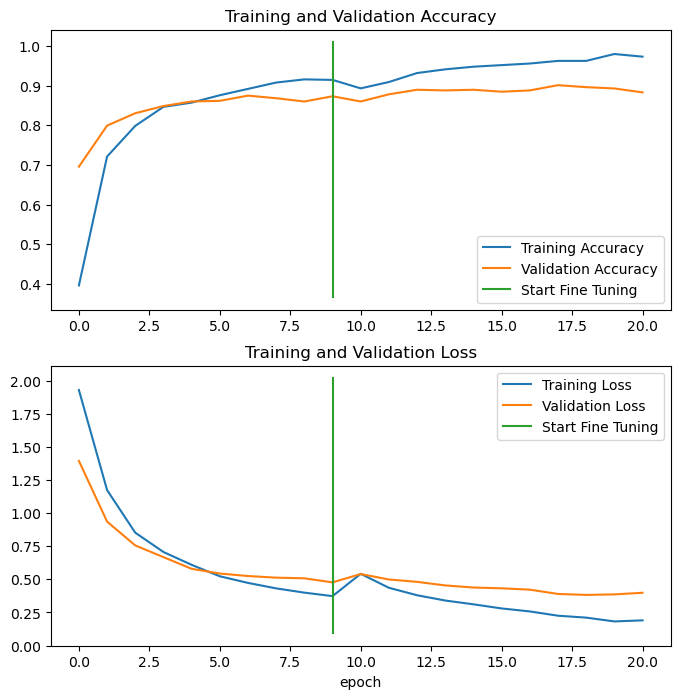

In [78]:
compare_historys(original_history=history_10_percent_exercise,
                new_history=history_fine_tune_10_percent_exercise_30_layers_freeze,
                initial_epochs=10)

#### 4.  Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [94]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

# Class names (from your train_data dataset)
class_names = train_data.class_names  

def plot_and_predict(model, dataset_dir, split="test", class_name=None):
    """
    Randomly selects an image from a dataset (train/test) and predicts its class using the given model.

    Args:
        model: Trained TensorFlow/Keras model.
        dataset_dir: Root dataset directory (e.g. '10_food_classes_10_percent').
        split: 'train' or 'test'.
        class_name: If provided, selects from that class, else picks random class.
    """

    def plot_and_predict(model, dataset_dir="10_food_classes_10_percent", split="test", class_name=None):
    # pick class
    if class_name is None:
        image_class = random.choice(os.listdir(os.path.join(dataset_dir, split)))
    else:
        image_class = class_name

    # pick image
    image_name = random.choice(os.listdir(os.path.join(dataset_dir, split, image_class)))
    image_path = os.path.join(dataset_dir, split, image_class, image_name)

    # load & preprocess
    image = mpimg.imread(image_path)
    img_resized = tf.image.resize(image, [224, 224])
    img_proc = preprocess_input(img_resized)  # ✅ correct preprocessing
    img_input = tf.expand_dims(img_proc, axis=0)

    # predict
    preds = model.predict(img_input, verbose=0)
    pred_class = train_data.class_names[tf.argmax(preds[0])]

    # plot
    plt.imshow(image)
    plt.title(f"True: {image_class} | Pred: {pred_class}")
    plt.axis("off")
    plt.show()

    return image_class, pred_class



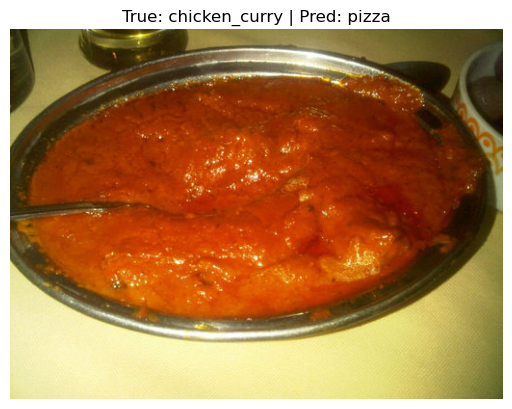

('chicken_curry', 'pizza')

In [110]:
plot_and_predict(model_0, '10_food_classes_10_percent')